<a href="https://colab.research.google.com/github/Niraj-kumbhar/CitiBike-NYC-2020/blob/main/Modeling_CitiBike2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Citi Bike Model Building

Data available on : [Citi Bike](https://s3.amazonaws.com/tripdata/index.html)

Citi Bike is a privately owned public bicycle sharing system serving the New York City boroughs of the Bronx, Brooklyn, Manhattan, and Queens, as well as Jersey City, New Jersey, and Hoboken, New Jersey.<br>
<br>
I have created notebook for detailed Analysis on this data, you can find this on [github](https://github.com/Niraj-kumbhar/CitiBike-NYC-2020/blob/main/EDA_CitiBikeHistory2020.ipynb)

## Loading Required Libraries

In [181]:
#for handling data
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# for vizualization
import seaborn as sns
sns.set()
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from  matplotlib.lines import Line2D
%matplotlib inline
import plotly.express as px

#for handling date
import datetime as dt
import holidays

# for splitting data
from sklearn.model_selection import train_test_split

# feature engineering and preprocessing
from sklearn.preprocessing import OneHotEncoder

# machine learning and deep learning
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

import tensorflow as tf
import keras
from keras.layers import Dense,Input,Embedding,LSTM,Dropout
from keras.models import Sequential
from keras import Model

#for supressing warnings
import warnings
warnings.filterwarnings("always")

## Loading Data
As we have already created final data csv in last EDA notebook, I will import it now

In [182]:
df = pd.read_csv('/content/drive/MyDrive/data/CitiBike2020.csv', index_col=0, parse_dates=['Date'], dtype={'Holiday':'int8'})

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     366 non-null    datetime64[ns]
 1   Trips    366 non-null    int64         
 2   Weekday  366 non-null    object        
 3   Holiday  366 non-null    int8          
dtypes: datetime64[ns](1), int64(1), int8(1), object(1)
memory usage: 11.8+ KB


In [184]:
df.head()

,Date,Trips,Weekday,Holiday
0,2020-01-01,18114,Wednesday,1
1,2020-01-02,41556,Thursday,0
2,2020-01-03,31873,Friday,0
3,2020-01-04,29436,Saturday,0
4,2020-01-05,27589,Sunday,0


### Using Weather data
I have downloaded Climate data for 1 station from [NOAA site](https://www.ncdc.noaa.gov/cdo-web/).
Lets analyse if it is affecteing no of trips  

In [185]:
df_weather = pd.read_csv('/content/drive/MyDrive/data/ClimetData.csv', parse_dates=['DATE'])

In [186]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   STATION          366 non-null    object        
 1   NAME             366 non-null    object        
 2   LATITUDE         366 non-null    float64       
 3   LONGITUDE        366 non-null    float64       
 4   ELEVATION        366 non-null    float64       
 5   DATE             366 non-null    datetime64[ns]
 6   AWND             329 non-null    float64       
 7   AWND_ATTRIBUTES  329 non-null    object        
 8   PGTM             0 non-null      float64       
 9   PGTM_ATTRIBUTES  0 non-null      float64       
 10  PRCP             366 non-null    float64       
 11  PRCP_ATTRIBUTES  366 non-null    object        
 12  SNOW             366 non-null    float64       
 13  SNOW_ATTRIBUTES  366 non-null    object        
 14  SNWD             366 non-null    float64  

In [187]:
# checking null in percentage
round(df_weather.isnull().sum()/366 *100, 2)

STATION              0.00
NAME                 0.00
LATITUDE             0.00
LONGITUDE            0.00
ELEVATION            0.00
DATE                 0.00
AWND                10.11
AWND_ATTRIBUTES     10.11
PGTM               100.00
PGTM_ATTRIBUTES    100.00
PRCP                 0.00
PRCP_ATTRIBUTES      0.00
SNOW                 0.00
SNOW_ATTRIBUTES      0.00
SNWD                 0.00
SNWD_ATTRIBUTES      0.00
TAVG               100.00
TAVG_ATTRIBUTES    100.00
TMAX                 0.00
TMAX_ATTRIBUTES      0.00
TMIN                 0.00
TMIN_ATTRIBUTES      0.00
TSUN               100.00
TSUN_ATTRIBUTES    100.00
WDF2                10.11
WDF2_ATTRIBUTES     10.11
WDF5                10.93
WDF5_ATTRIBUTES     10.93
WSF2                10.11
WSF2_ATTRIBUTES     10.11
WSF5                10.93
WSF5_ATTRIBUTES     10.93
WT01                58.20
WT01_ATTRIBUTES     58.20
WT02                97.81
WT02_ATTRIBUTES     97.81
WT03                92.62
WT03_ATTRIBUTES     92.62
WT04        

In [188]:
# as there are a lot of null values present, we will drop columns with null

df_climate= df_weather[['DATE','TMAX','TMIN','SNOW']]
df_climate.head()

,DATE,TMAX,TMIN,SNOW
0,2020-01-01,41,34,0.0
1,2020-01-02,49,33,0.0
2,2020-01-03,49,44,0.0
3,2020-01-04,51,41,0.0
4,2020-01-05,42,35,0.0


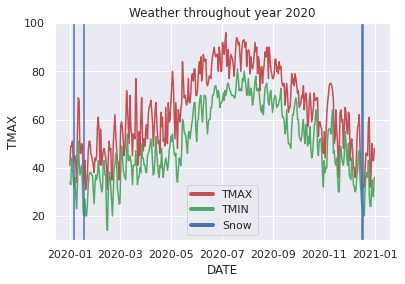

In [189]:
# plotting normal line chart over Date
sns.lineplot(data=df_climate, x='DATE',y='TMAX', color='r')
sns.lineplot(data=df_climate, x='DATE',y='TMIN', color='g')
plt.rcParams["figure.figsize"] = (40,10)
plt.title('Weather throughout year 2020');


# Thanks to: https://stackoverflow.com/questions/35906717/marking-specific-dates-when-visualizing-a-time-series
ax = plt.gca()
label_list = [date for i, date in enumerate(df_climate['DATE']) if df_climate['SNOW'][i]>0.0]

for date_point in label_list:
    plt.axvline(x=date_point, color='b')


legend_elements = [Line2D([0], [0], color='r', lw=4, label='TMAX'),
                Line2D([0], [0], color='g', lw=4, label='TMIN'),
                Line2D([0], [0], color='b', lw=4, label='Snow')]
plt.legend(handles=legend_elements)
plt.show()

Lets Join both Datasets

In [190]:
df_modeling = df.merge(df_climate, how='inner', left_on='Date', right_on='DATE')

Text(0.5, 0, 'Tmin, °F')

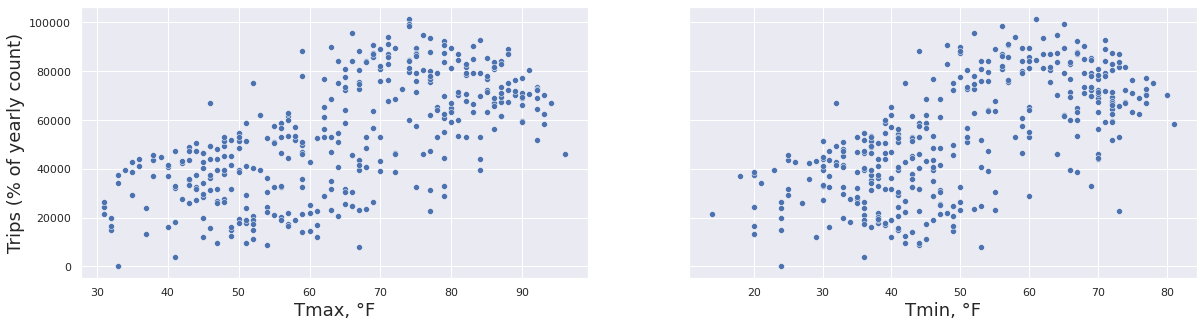

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.scatterplot(x=df_modeling['TMAX'], y=df_modeling['Trips'], ax=axs[0])
axs[0].set_xlabel('Tmax, °F', fontsize=18)
axs[0].set_ylabel('Trips (% of yearly count)', fontsize=18)
#axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

sns.scatterplot(x=df_modeling['TMIN'], y=df_modeling['Trips'], ax=axs[1])
axs[1].set_xlabel('Tmin, °F', fontsize=18)



Text(0.5, 0, 'Snowfall, inches')

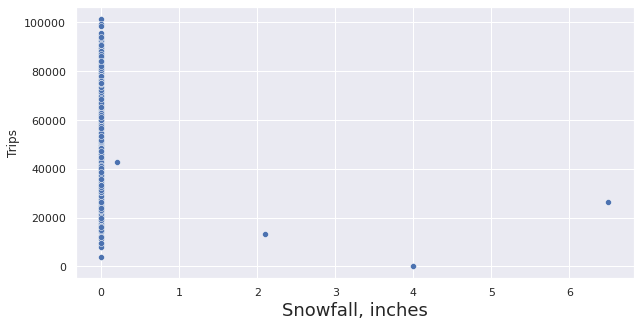

In [192]:
plt.figure(figsize=(10,5))
axs= sns.scatterplot(x=df_modeling["SNOW"], y=df_modeling["Trips"])
axs.set_xlabel('Snowfall, inches', fontsize=18)

* Trips increase when temperature increases, until its hotest day 
* People choose not use bikes on when there is Snowfall

## Feature Engineering
We will create some new features using same data
* We create new columns to indicate each day (using dummy columns)
* will Create new features to indicate day of the year and month
* will create column to indicate year
* We can drop one DATE column
* SNOW can be useful but while predicting for future, you need to have snow prediction also

In [193]:
df_modeling.drop(columns=['DATE','SNOW'], inplace=True)
df_modeling.head()

,Date,Trips,Weekday,Holiday,TMAX,TMIN
0,2020-01-01,18114,Wednesday,1,41,34
1,2020-01-02,41556,Thursday,0,49,33
2,2020-01-03,31873,Friday,0,49,44
3,2020-01-04,29436,Saturday,0,51,41
4,2020-01-05,27589,Sunday,0,42,35


In [194]:
#changing SNOW feature to binary categorical 
#df_modeling['SNOW'] = df_modeling['SNOW'].apply(lambda x : 1 if x>0 else 0)

In [195]:
data = df_modeling.copy()


In [197]:
# creating day of the year feature
df_modeling['DOY'] = df_modeling['Date'].dt.dayofyear

# creating day of the week feature
df_modeling['DOW'] = df_modeling['Date'].dt.dayofweek

# creating day of the month feature
df_modeling['DOM'] = df_modeling['Date'].dt.day

# creating year column
df_modeling['year'] = df_modeling['Date'].dt.year

# creating month number column
df_modeling['month_num'] = df_modeling['Date'].dt.month

#creating month feature
df_modeling['month'] = df_modeling['Date'].dt.month_name()

In [198]:
#data preview
df_modeling.head(10)

,Date,Trips,Weekday,Holiday,TMAX,TMIN,DOY,DOW,DOM,year,month_num,month
0,2020-01-01,18114,Wednesday,1,41,34,1,2,1,2020,1,January
1,2020-01-02,41556,Thursday,0,49,33,2,3,2,2020,1,January
2,2020-01-03,31873,Friday,0,49,44,3,4,3,2020,1,January
3,2020-01-04,29436,Saturday,0,51,41,4,5,4,2020,1,January
4,2020-01-05,27589,Sunday,0,42,35,5,6,5,2020,1,January
5,2020-01-06,42738,Monday,0,45,32,6,0,6,2020,1,January
6,2020-01-07,46535,Tuesday,0,45,36,7,1,7,2020,1,January
7,2020-01-08,42400,Wednesday,0,42,28,8,2,8,2020,1,January
8,2020-01-09,39344,Thursday,0,34,23,9,3,9,2020,1,January
9,2020-01-10,50800,Friday,0,55,33,10,4,10,2020,1,January


### Categorical feature encoding

In [199]:
df_data = pd.get_dummies(df_modeling, columns=['Weekday','month'], drop_first=True)
df_data.head()

,Date,Trips,Holiday,TMAX,TMIN,DOY,DOW,DOM,year,month_num,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,2020-01-01,18114,1,41,34,1,2,1,2020,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,2020-01-02,41556,0,49,33,2,3,2,2020,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2020-01-03,31873,0,49,44,3,4,3,2020,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2020-01-04,29436,0,51,41,4,5,4,2020,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2020-01-05,27589,0,42,35,5,6,5,2020,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Modelling

In [200]:
# THANKS TO https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb

def metric_calc(model, xtrain, ytrain, xtest, ytest):
    """
    To plot the metrics and graph of regression
    ==============================================
    inputs:
      model: Model selected
      xtrain: input for train
      ytrain: ground truth for xtrain
      xtest: input for test
      ytest: ground truth for xtest
    outputs:
      PRINT --> Metrics R2_score, MAE, MSE, RMSE for both Train and validation
      RETURN --> Metrics for Validation

    """
    y_pred_train = model.predict(xtrain)
    r2_train = r2_score(ytrain,y_pred_train)
    mae_train = mean_absolute_error(ytrain,y_pred_train)
    mse_train = mean_squared_error(ytrain,y_pred_train)
    rmse_train = np.sqrt(mse_train)    
    
    metrics_train = {}
    metrics_train['R2_Score'] = r2_train
    metrics_train['MAE'] = mae_train
    metrics_train['MSE'] = mse_train
    metrics_train['RMSE'] = rmse_train
    
    y_pred = model.predict(xtest)
    r2 = r2_score(ytest,y_pred)
    mae = mean_absolute_error(ytest,y_pred)
    mse = mean_squared_error(ytest, y_pred)
    rmse = np.sqrt(mse)
    
    metrics = {}
    metrics['R2_Score'] = r2
    metrics['MAE'] = mae
    metrics['MSE'] = mse
    metrics['RMSE'] = rmse

    print("="*20,"Model Metrics - Train","="*20)
    print(pd.DataFrame([metrics_train]))    
    print("\n")
    print("="*20,"Model Metrics - Test","="*20)
    print(pd.DataFrame([metrics]))
    print("\n")
    plt.rcParams.update({'figure.figsize': (15, 3)})
    fig, ax = plt.subplots()
    sns.lineplot(data=ytest, x=ytest.index, y='Trips')
    sns.lineplot(x=ytest.index, y=pd.DataFrame(y_pred)[0], color='r')
    plt.grid(linestyle='-', linewidth=0.3)
    legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual'),
                Line2D([0], [0], color='r', lw=4, label='Predicted')]
    plt.legend(handles=legend_elements)
    #ax.tick_params(axis='x', rotation=90)
    
    return metrics


In [201]:
X_train, X_test, y_train, y_test = train_test_split(df_data.drop(columns=['Trips','Date']), df_data[['Trips']], shuffle=False, test_size=0.2)

### Model Evaluation

__Linear Regression__

==================== Model Metrics - Train ====================
   R2_Score          MAE           MSE          RMSE
0  0.734317  9301.066197  1.517908e+08  12320.340932


==================== Model Metrics - Test ====================
   R2_Score           MAE           MSE          RMSE
0 -0.440947  20409.196081  6.472827e+08  25441.751898




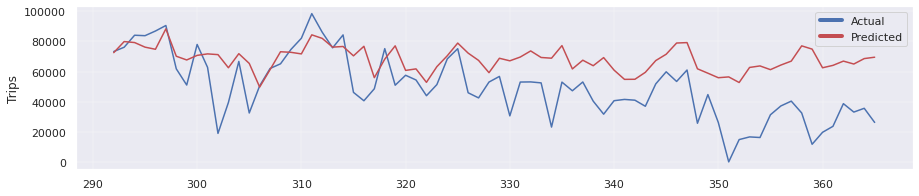

In [202]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_metrics = metric_calc(lr, X_train, y_train, X_test, y_test)

__Random Forest Regressor__

<ipython-input-203-cbe3ac106029>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


==================== Model Metrics - Train ====================
   R2_Score          MAE           MSE         RMSE
0  0.961255  3424.432375  2.213574e+07  4704.863525


==================== Model Metrics - Test ====================
   R2_Score           MAE           MSE          RMSE
0  0.315311  13879.883341  3.075666e+08  17537.575579




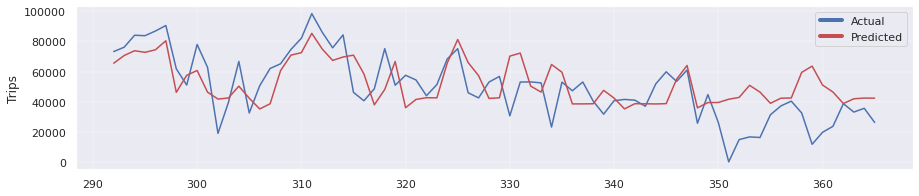

In [203]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=8)
rf.fit(X_train, y_train)
rf_metrics = metric_calc(rf, X_train, y_train, X_test, y_test)

__Xgboost Regression__

[17:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Model Metrics - Train ====================
   R2_Score         MAE           MSE       RMSE
0  0.999847  190.604643  87407.024633  295.64679


==================== Model Metrics - Test ====================
   R2_Score           MAE           MSE          RMSE
0 -0.120602  18059.543708  5.033818e+08  22436.170761




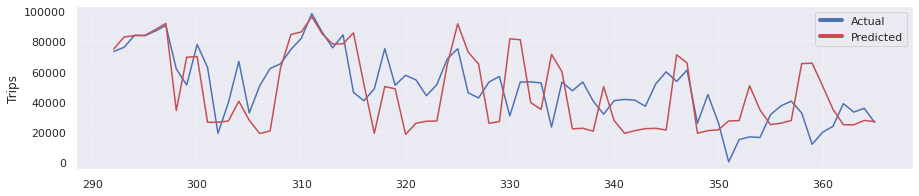

In [204]:
# hyperparameters set 1
xgb1 = XGBRegressor(n_estimators=800, max_depth=10, learning_rate=0.01, n_jobs=-1)
xgb1.fit(X_train, y_train)
xgb1_metrics = metric_calc(xgb1, X_train, y_train, X_test, y_test)

[17:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Model Metrics - Train ====================
   R2_Score           MAE           MSE          RMSE
0   0.02252  20808.901875  5.584568e+08  23631.690582


==================== Model Metrics - Test ====================
   R2_Score           MAE           MSE          RMSE
0 -1.290425  28110.187441  1.028874e+09  32076.064493




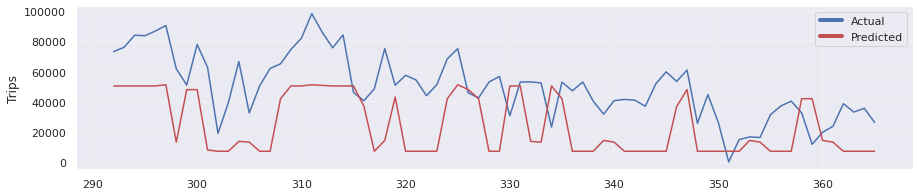

In [205]:
# hyperparamters set 2
xgb2 = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.001, n_jobs=-1)
xgb2.fit(X_train, y_train)
xgb2_metrics = metric_calc(xgb2, X_train, y_train, X_test, y_test)

### Metric Evaluation

In [206]:
ML_comparison = pd.DataFrame([lr_metrics,rf_metrics,xgb1_metrics,xgb2_metrics],
                             index=['LinearRegression','RandomForest Regressor','XGBoostRegressor1','XGBoostRegressor2'])
ML_comparison.sort_values(by='RMSE')

,R2_Score,MAE,MSE,RMSE
RandomForest Regressor,0.315311,13879.883341,3.075666e+08,17537.575579
XGBoostRegressor1,-0.120602,18059.543708,5.033818e+08,22436.170761
LinearRegression,-0.440947,20409.196081,6.472827e+08,25441.751898
XGBoostRegressor2,-1.290425,28110.187441,1.028874e+09,32076.064493


* RandomForestRegressor is performing well, and able to capture the trends
* We can start our final model training with __RandomForest Regressor__

## Model Finalization

Now we will train our model on whole year 2020 data and will test it on Q1 of 2021.
* We can get Holiday information for Q1 of 2021 by using same Holiday API.
* We can extract all date features from date column

In [207]:
df_modeling.tail()

,Date,Trips,Weekday,Holiday,TMAX,TMIN,DOY,DOW,DOM,year,month_num,month
361,2020-12-27,23764,Sunday,0,37,24,362,6,27,2020,12,December
362,2020-12-28,38784,Monday,0,50,35,363,0,28,2020,12,December
363,2020-12-29,33202,Tuesday,0,43,30,364,1,29,2020,12,December
364,2020-12-30,35705,Wednesday,0,43,28,365,2,30,2020,12,December
365,2020-12-31,26334,Thursday,0,48,36,366,3,31,2020,12,December


In [208]:
df_test = pd.DataFrame(columns=['Date', 'Weekday', 'Holiday', 'TMAX', 'TMIN', 'DOY', 'DOW', 'DOM', 'month', 'year', 'month_num'])

In [209]:
df_test['Date'] = pd.date_range(start='1/1/2021',end='31/3/2021')
df_test['Weekday'] = df_test.Date.dt.day_name()
df_test['Holiday'] = [1 if d in holidays.US() else 0 for d in df_test["Date"]]
df_test['DOY'] = df_test.Date.dt.dayofyear
df_test['DOW'] = df_test.Date.dt.dayofweek
df_test['DOM'] = df_test.Date.dt.day
df_test['month'] = df_test.Date.dt.month_name()
df_test['year'] = df_test.Date.dt.year
df_test['month_num'] = df_test.Date.dt.month

In [210]:
df_test.head()

,Date,Weekday,Holiday,TMAX,TMIN,DOY,DOW,DOM,month,year,month_num
0,2021-01-01,Friday,1,NaN,NaN,1,4,1,January,2021,1
1,2021-01-02,Saturday,0,NaN,NaN,2,5,2,January,2021,1
2,2021-01-03,Sunday,0,NaN,NaN,3,6,3,January,2021,1
3,2021-01-04,Monday,0,NaN,NaN,4,0,4,January,2021,1
4,2021-01-05,Tuesday,0,NaN,NaN,5,1,5,January,2021,1


In [211]:
jan_min = int(df_modeling[df_modeling['month_num']==1]['TMIN'].mean())
feb_min = int(df_modeling[df_modeling['month_num']==2]['TMIN'].mean())
mar_min = int(df_modeling[df_modeling['month_num']==3]['TMIN'].mean())
# avgerage by previous year month
jan_max = int(df_modeling[df_modeling['month_num']==1]['TMAX'].mean())
feb_max = int(df_modeling[df_modeling['month_num']==2]['TMAX'].mean())
mar_max = int(df_modeling[df_modeling['month_num']==3]['TMAX'].mean())

In [212]:
df_test['TMIN'] = df_test['month_num'].apply(lambda x: jan_min if x==1 else(feb_min if x==2 else mar_min))
df_test['TMAX'] = df_test['month_num'].apply(lambda x: jan_max if x==1 else(feb_max if x==2 else mar_max))

In [222]:
test = df_test.drop(columns=['Date'])
features = test.columns.to_list()
test.head()

,Weekday,Holiday,TMAX,TMIN,DOY,DOW,DOM,month,year,month_num
0,Friday,1,45,33,1,4,1,January,2021,1
1,Saturday,0,45,33,2,5,2,January,2021,1
2,Sunday,0,45,33,3,6,3,January,2021,1
3,Monday,0,45,33,4,0,4,January,2021,1
4,Tuesday,0,45,33,5,1,5,January,2021,1


In [223]:
X = df_modeling[features]
y = df_modeling['Trips']
X.head()

,Weekday,Holiday,TMAX,TMIN,DOY,DOW,DOM,month,year,month_num
0,Wednesday,1,41,34,1,2,1,January,2020,1
1,Thursday,0,49,33,2,3,2,January,2020,1
2,Friday,0,49,44,3,4,3,January,2020,1
3,Saturday,0,51,41,4,5,4,January,2020,1
4,Sunday,0,42,35,5,6,5,January,2020,1


### Making pipeline

In [224]:
# for getting dummy
ohe = ColumnTransformer([('ohe_week_month',OneHotEncoder(),[0,7])],remainder='passthrough')

#Creating model
model = RandomForestRegressor(n_estimators=1000, max_depth=8)
# pipeline
pipe = Pipeline([
    ('columnTransformer',ohe),
    ('model',model)
])

In [225]:
pipe.fit(X,y)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_week_month',
                                                  OneHotEncoder(), [0, 7])])),
                ('model',
                 RandomForestRegressor(max_depth=8, n_estimators=1000))])

In [228]:
# prediction
y_pred = pipe.predict(test)
df_test['Trips'] = y_pred

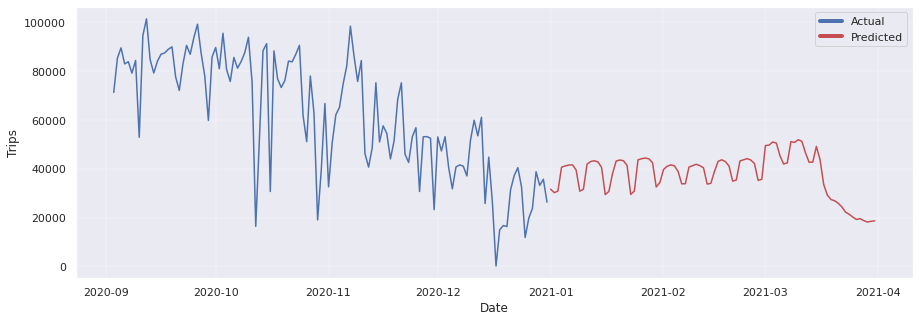

In [234]:
plt.rcParams.update({'figure.figsize': (15, 5)})
fig, ax = plt.subplots()
sns.lineplot(data=df_modeling.tail(120), x='Date', y='Trips')
sns.lineplot(data=df_test, x='Date', y='Trips', color='r')
plt.grid(linestyle='-', linewidth=0.3)
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual'),
                Line2D([0], [0], color='r', lw=4, label='Predicted')]
plt.legend(handles=legend_elements)

## Reference:
* YouTube channel: [CodeEmporium](https://www.youtube.com/watch?v=Wsfz3i1AXzY)
* Python Holidays Library : [Holidays](https://pypi.org/project/holidays/)
* Weather Data: [NOAA](https://www.ncdc.noaa.gov/cdo-web/)
* Data Vizualization : 
  * https://stackoverflow.com/questions/35906717/marking-specific-dates-when-visualizing-a-time-series
  * https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
* Handling large data in Pandas : [Article_link](https://pythonspeed.com/articles/pandas-load-less-data/)
* Visualization cheatsheet: [link](https://www.data-to-viz.com/)
* Analysis by Others: [NYC-Taxi](https://medium.com/analytics-vidhya/exploratory-data-analysis-of-nyc-taxi-trip-duration-dataset-using-python-257fdef2749e) [NYC-Data science academy](https://nycdatascience.com/blog/student-works/embrace-the-new-normal-citi-bike-jersey-city-and-hoboken-data-analysis/)
* `metric_calc` function inspired from [github.com/prateeknigam9/](https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb)